In [1]:
!pip install pygame pyvirtualdisplay

In [2]:
!apt install swig && pip install gymnasium box2d box2d-kengz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 2s (609 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126281 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubunt

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, HTML
import base64
import os

In [4]:
env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
print(env.observation_space)
print(env.action_space)

Box([-3.1415927 -5.        -5.        -5.        -3.1415927 -5.
 -3.1415927 -5.        -0.        -3.1415927 -5.        -3.1415927
 -5.        -0.        -1.        -1.        -1.        -1.
 -1.        -1.        -1.        -1.        -1.        -1.       ], [3.1415927 5.        5.        5.        3.1415927 5.        3.1415927
 5.        5.        3.1415927 5.        3.1415927 5.        5.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.       ], (24,), float32)
Box(-1.0, 1.0, (4,), float32)


In [5]:
env.observation_space.sample()

array([ 2.1244984 , -3.7975051 ,  4.5767684 , -4.6491985 ,  0.34394172,
        3.077253  ,  2.470214  , -1.1688544 ,  4.532486  , -1.8504655 ,
        0.7156655 , -2.6017132 ,  0.0406498 ,  2.5901086 ,  0.63311386,
       -0.88267285, -0.04080293, -0.23595263, -0.25262082,  0.56387645,
       -0.7849533 , -0.9389143 ,  0.5344842 , -0.9391037 ], dtype=float32)

In [6]:
env.action_space.sample()

array([-0.8795578 , -0.4630204 ,  0.20224486,  0.45432305], dtype=float32)

In [7]:
from itertools import combinations_with_replacement

def polynomial_features(state, degree=1):
    """
    Generate a polynomial basis feature vector from a state.

    Parameters:
        state: array-like
        degree: int, the maximum total degree of polynomial terms

    Returns:
        feature_vector: np.ndarray, shape (num_features,)
    """
    state = np.asarray(state)
    size = state.shape[0]

    # Create index tuples for all monomials up to the given degree
    feature_vector = [1.0]  # bias term
    for d in range(1, degree + 1):
        for idxs in combinations_with_replacement(range(size), d):
            term = 1.0
            for i in idxs:
                term *= state[i]
            feature_vector.append(term)

    return np.array(feature_vector).reshape(-1)


In [22]:
from math import isinf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

alpha_sv_estimates = .01
alpha_policy_updates = .05
gamma = 0.9 #discount factor on future rewards
num_episodes = 1000
dim = polynomial_features(env.observation_space.sample()).shape[0]
wts = np.random.normal(size=dim)
action_dim = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs_per_batch = 5
epsilon = .03

class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 12)
        self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(12, 1)

    def forward(self, state):

        if torch.isnan(state).any():
          print("NaNs in features!")
        if torch.isinf(state).any():
          print("Infs in features!")

        x = F.relu(self.fc1(state))

        if torch.isnan(x).any():
          print("NaNs detected in output of layer 1!")

        if torch.isinf(x).any():
          print("Infs detected in output of layer 1!")

        y = F.relu(self.fc2(x))

        if torch.isnan(y).any():
          print("NaNs detected in output of layer 2!")

        if torch.isinf(y).any():
          print("Infs detected in output of layer 2!")

        value = self.fc3(y)

        if torch.isnan(value).any():
          print("NaNs detected in final value estimate!")

        if torch.isinf(value).any():
          print("Infs detected in final value estimate!")

        return value



class PPOPolicy(nn.Module):
    def __init__(self, obs_dim, action_dim=4, hidden_sizes=(64, 64)):
        super().__init__()
        layers = []
        input_dim = obs_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        self.shared = nn.Sequential(*layers)

        self.mean_head = nn.Linear(input_dim, action_dim)
        self.log_std_head = nn.Linear(input_dim, action_dim)

    def forward(self, obs):
        x = self.shared(obs)

        if torch.isnan(x).any():
            print("NaNs detected in shared layers output!")
        if torch.isinf(x).any():
            print("Infs detected in shared layers output!")

        mean = self.mean_head(x)  # shape: [batch_size, action_dim]

        if torch.isnan(mean).any():
            print("NaNs detected in mean head output!")
        if torch.isinf(mean).any():
            print("Infs detected in mean head output!")


        log_std = self.log_std_head(x)

        if torch.isnan(log_std).any():
            print("NaNs detected in log_std head output!")
        if torch.isinf(log_std).any():
            print("Infs detected in log_std head output!")

        std = torch.exp(log_std)  # shape: [batch_size, action_dim]
        if torch.isnan(std).any():
            print("NaNs detected in std (exp(log_std)) output!")
        if torch.isinf(std).any():
            print("Infs detected in std (exp(log_std)) output!")


        return mean, std

    def sample_action(self, obs):
        mean, std = self.forward(obs)
        dist = Normal(mean, std)
        action = dist.rsample()  # rsample allows gradients for reparameterization trick

        # Check for NaNs or Infs in action
        if torch.isnan(action).any():
            print("NaNs detected in sampled action!")
        if torch.isinf(action).any():
            print("Infs detected in sampled action!")

        log_prob = dist.log_prob(action).sum(-1)

        # Check for NaNs or Infs in log_prob
        if torch.isnan(log_prob).any():
            print("NaNs detected in log_prob!")
        if torch.isinf(log_prob).any():
            print("Infs detected in log_prob!")

        # Clip action to be within [-1, 1]
        clipped_action = torch.clamp(action, -1.0, 1.0)
        return clipped_action, log_prob


def compute_log_probs(policy_net, states, actions):
    """
    Compute log-probabilities of actions under the current policy for PPO.

    Args:
        policy_net: A neural network with a forward method returning (mean, std).
        states: Tensor of shape [batch_size, obs_dim].
        actions: Tensor of shape [batch_size, action_dim].

    Returns:
        log_probs: Tensor of shape [batch_size], differentiable w.r.t. policy_net parameters.
    """
    mean, std = policy_net(states)               # [batch_size, action_dim]
    dist = Normal(mean, std)
    log_probs = dist.log_prob(actions).sum(dim=-1)  # Sum over action dims
    return log_probs


def select_action(policy_network, state):
    features = polynomial_features(state)
    if np.isnan(features).any():
      print("NaNs in features!")
    if torch.isinf(torch.tensor(features)).any():
      print("Infs in features!")
    input = torch.tensor(features, dtype=torch.float32).to(device)
    action, log_prob = policy_network.sample_action(input)

    if torch.isnan(action).any():
      print("Action:", action)
    if torch.isinf(action).any():
      print("Action:", action)
    if torch.isnan(log_prob).any():
      print("Log_prob:", log_prob)
    if torch.isinf(log_prob).any():
      print("Log_prob:", log_prob)

    return action.detach().cpu().numpy(), log_prob

def get_state_value(input):
  value = value_network(input)
  return value

def safe_normalize(tensor: torch.Tensor, eps=1e-8):
    if torch.isnan(tensor).any():
        return tensor  # skip normalization
    if torch.isinf(tensor).any():
        return tensor  # skip normalization

    mean = tensor.mean()
    std = tensor.std()

    if torch.isnan(mean) or torch.isnan(std) or std < eps:
        return tensor  # skip normalization

    return (tensor - mean) / (std + eps)

In [23]:
policy_network = PPOPolicy(dim).to(device)
policy_optimizer = torch.optim.Adam(policy_network.parameters(), lr=alpha_policy_updates)
value_network = ValueNetwork(dim).to(device)
value_optimizer = torch.optim.Adam(value_network.parameters(), lr=alpha_sv_estimates)

for episode_idx in range(num_episodes):
    rewards = [] #stores rewards of each time step in episode
    actions = [] #stores actions taken in episode under behavior policy
    states = [] #stores states visited in episode by behavior policy
    probs = [] #stores pi(a|s) for each state,action pair in episode under behavior policy; detached from computation graph

    obs, _ = env.reset()
    undiscounted_reward_sum = 0
    done = False

    while not done:
        states.append(obs)
        action, log_prob = select_action(policy_network, obs) #forward pass thru policy network using cur state (obs) and returns action (discrete idx) and log_prob of that action
        prob = torch.exp(log_prob).detach() #probability of the discrete action BUT NOT the sampled action; need to divide
        probs.append(prob)
        obs, reward, terminated, truncated, _ = env.step(action)


        actions.append(action) #store the discrete action index
        undiscounted_reward_sum += reward
        rewards.append(reward)
        done = terminated or truncated


    # Compute discounted returns
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)

    # Compute advantages and update baseline weights
    features_np = np.array([polynomial_features(s) for s in states])  # shape: [B, D]
    features_tensor = torch.tensor(features_np, dtype=torch.float32, device=device)  # shape: [B, D]

    # Step 2: Forward pass through value network (keep graph for backprop)
    baselines = value_network(features_tensor).squeeze(-1)  # shape: [B]

    # Step 3: Convert returns to tensor
    returns_tensor = torch.tensor(returns, dtype=torch.float32, device=device)  # shape: [B]

    # Step 4: Compute advantages (still requires gradient w.r.t. value net if you do (G - V(s))^2 loss later)

    advantages = returns_tensor - baselines  # shape: [B]
    #advantages = safe_normalize(advantages)
    advantages = advantages.detach()

    for i in range(epochs_per_batch):
      clipped_vals = []
      unclipped_vals = []

      state_features_np = np.array([polynomial_features(s) for s in states])  # shape: [batch_size, feature_dim]
      states_tensor = torch.tensor(state_features_np, dtype=torch.float32, device=device)
      actions_tensor = torch.tensor(actions, dtype=torch.float32, device=device)
      old_probs_tensor = torch.tensor(probs, dtype=torch.float32, device=device)

      new_log_probs = compute_log_probs(policy_network, states_tensor, actions_tensor)
      new_probs = torch.exp(new_log_probs)

      # Compute ratios
      ratios = new_probs / (old_probs_tensor + 1e-8)  # shape: [batch]


      # PPO clipped objective (vectorized)
      clipped_ratios = torch.clamp(ratios, 1 - epsilon, 1 + epsilon)
      clipped_obj = clipped_ratios * advantages
      unclipped_obj = ratios * advantages


      loss_per_step = -torch.min(unclipped_obj, clipped_obj)  # shape: [batch]
      loss = loss_per_step.mean()

      if torch.isnan(loss):
        print("NaN loss detected")
        #print("old_probs", old_probs_tensor)
        #print("new_probs:", new_probs)
        #print("ratios:", ratios)
        #print("advantages:", advantages)
        #print("unclipped:", unclipped_obj)
        #print("clipped:", clipped_obj)

      policy_optimizer.zero_grad()
      loss.backward()

      for name, param in policy_network.named_parameters():
        if param.grad is not None and torch.isnan(param.grad).any():
          print(f"NaN in gradient of {name}")
        if param.grad is not None and torch.norm(param.grad) > 1e6:
          print(f"Exploding gradient in {name}:", torch.norm(param.grad).item())
      torch.nn.utils.clip_grad_norm_(policy_network.parameters(), max_norm=1.0)
      policy_optimizer.step()


    value_loss = F.mse_loss(baselines, returns_tensor)
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    if (episode_idx+1) % 100 == 0:
        print('Episode: {} reward: '.format(episode_idx+1), undiscounted_reward_sum)
        #print('Episode {} value loss: '.format(episode_idx+1), value_loss.item())
        #print("Advantage stats: mean =", advantages.mean().item(), "std =", advantages.std().item())
        #print("Sample advantages:", advantages[:5].detach().cpu().numpy())


NaNs detected in log_prob!
Log_prob: tensor(nan, device='cuda:0', grad_fn=<SumBackward1>)
NaNs detected in log_prob!
Log_prob: tensor(nan, device='cuda:0', grad_fn=<SumBackward1>)
NaNs detected in log_prob!
Log_prob: tensor(nan, device='cuda:0', grad_fn=<SumBackward1>)
NaNs detected in log_prob!
Log_prob: tensor(nan, device='cuda:0', grad_fn=<SumBackward1>)
NaNs detected in log_prob!
Log_prob: tensor(nan, device='cuda:0', grad_fn=<SumBackward1>)
NaNs detected in log_prob!
Log_prob: tensor(nan, device='cuda:0', grad_fn=<SumBackward1>)
NaNs detected in log_prob!
Log_prob: tensor(nan, device='cuda:0', grad_fn=<SumBackward1>)
NaNs detected in log_prob!
Log_prob: tensor(nan, device='cuda:0', grad_fn=<SumBackward1>)
NaNs detected in log_prob!
Log_prob: tensor(nan, device='cuda:0', grad_fn=<SumBackward1>)
NaNs detected in log_prob!
Log_prob: tensor(nan, device='cuda:0', grad_fn=<SumBackward1>)
NaNs detected in log_prob!
Log_prob: tensor(nan, device='cuda:0', grad_fn=<SumBackward1>)
NaNs detec

ValueError: Expected parameter loc (Tensor of shape (71, 4)) of distribution Normal(loc: torch.Size([71, 4]), scale: torch.Size([71, 4])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
rewards = []
for episode_idx in range(100):
    obs, _ = env.reset()
    done = False
    reward_sum = 0
    while not done:
        action, log_prob = select_action(policy_network, obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        reward_sum += reward
        done = terminated or truncated

    rewards.append(reward_sum)


print(sum(rewards)/len(rewards))


-200.0


-200.0


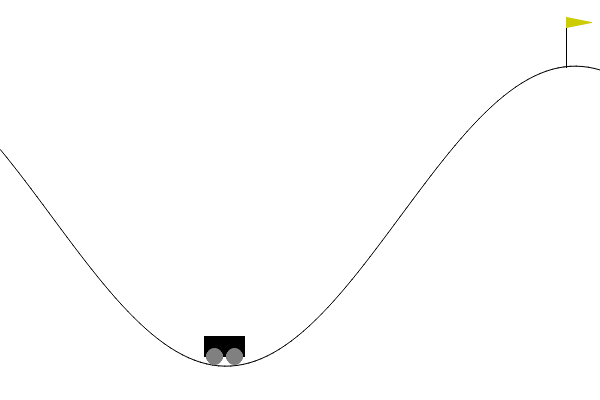

In [ ]:
reward_sum = 0
obs, _ = env.reset() #reset the env to get initial state

frames = []

done = False
while not done:
    frame = env.render()
    frames.append(Image.fromarray(frame))
    action, _ = select_action(policy_network, obs)
    obs, reward, terminated, truncated, _ = env.step(action)
    reward_sum += reward
    done = terminated or truncated

env.close()
print(reward_sum)
# Save to GIF
frames[0].save("mountain_car.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)

# Display the GIF in notebook
from IPython.display import Image as IPyImage
IPyImage(filename="mountain_car.gif")